## imports

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import progressbar
import tensorflow as tf
import scipy

!rm -d -f -r rm *.zip
!rm -d -f -r rm *.npy

!rm -rf images
!rm -rf visualized


In [6]:
!wget -nc https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/joints.mat
poses=scipy.io.loadmat('joints.mat')['joints']

!wget  -nc https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/images.zip
!unzip -q /content/images.zip


--2021-12-27 15:59:42--  https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/joints.mat
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_2/main/lsp_dataset/joints.mat [following]
--2021-12-27 15:59:43--  https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_2/main/lsp_dataset/joints.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440523 (430K) [application/octet-stream]
Saving to: ‘joints.mat’

joints.mat          100%[===================>] 430.20K  --.-KB/s    in 0.04s   

2021-12-27 15:59:43 (9.65 MB/s) - ‘joints.mat’ saved [440523/440523]

--202

## functions

In [38]:

def test_pcp(model , joint_index ) :
  # joint_index =['Right elbow','Right wrist']
  joint_index=['Right elbow','Right wrist' ,'Right knee' , 'Right hip' , 'Left hip',  'Left knee',  'Left ankle', 'Right shoulder',
  'Left shoulder',   'Left elbow',   'Left wrist',  'Neck',   'Head top' , 'Right ankle']

  name2index={'Right ankle':0,
  'Right knee':1,
  'Right hip':2,
  'Left hip':3,
  'Left knee':4,
  'Left ankle':5,
  'Right wrist':6,
  'Right elbow':7,
  'Right shoulder':8,
  'Left shoulder':9,
  'Left elbow':10,
  'Left wrist':11,
  'Neck':12,
  'Head top':13}


  min_d,max_d=0,1
  pred=model.predict(my_dataset['test images'])
  true=my_dataset['test poses']

  pred_x,pred_y=pred[:,:14],pred[:,14:]
  true_x,true_y=true[:,0],true[:,1]

  true_R_ELBOW_x = true_x [7]
  true_R_ELBOW_Y = true_x [7]
  true_R_WRIST_X = true_y [6]
  true_R_WRIST_y = true_y [6]
  true_distance =  np.sqrt( (true_R_ELBOW_x-true_R_WRIST_X)**2 + (true_R_ELBOW_Y-true_R_WRIST_y)**2)
  distance=np.sqrt((pred_x-true_x)**2+(pred_y-true_y)**2)


  arr=[[]for _ in joint_index]
  for x in np.arange(min_d,max_d,0.001):
    for idx,joint in enumerate(joint_index):
      arr[idx].append(np.sum(distance<x,axis=0)[name2index[joint]]/pred.shape[0])
  for idx,joint in enumerate(joint_index):
    plt.plot(np.arange(min_d,max_d,0.001),arr[idx],label=joint)
  plt.legend()
  plt.show()

In [39]:
def test_pdj(model,joint_index):
  joint_index=['Right elbow','Right wrist' ,'Right knee' , 'Right hip' , 'Left hip',  'Left knee',  'Left ankle', 'Right shoulder',
  'Left shoulder',   'Left elbow',   'Left wrist',  'Neck',   'Head top', 'Right ankle']
  name2index={'Right ankle':0,
  'Right knee':1,
  'Right hip':2,
  'Left hip':3,
  'Left knee':4,
  'Left ankle':5,
  'Right wrist':6,
  'Right elbow':7,
  'Right shoulder':8,
  'Left shoulder':9,
  'Left elbow':10,
  'Left wrist':11,
  'Neck':12,
  'Head top':13}
  min_d,max_d=0,1
  pred=model.predict(my_dataset['test images'])
  true=my_dataset['test poses']

  pred_x,pred_y=pred[:,:14],pred[:,14:]
  true_x,true_y=true[:,0],true[:,1]

  distance=np.sqrt((pred_x-true_x)**2+(pred_y-true_y)**2)
  arr=[[]for _ in joint_index]
  for x in np.arange(min_d,max_d,0.001):
    for idx,joint in enumerate(joint_index):
      arr[idx].append(np.sum(distance<x,axis=0)[name2index[joint]]/pred.shape[0])
  for idx,joint in enumerate(joint_index):
    plt.plot(np.arange(min_d,max_d,0.001),arr[idx],label=joint)
  plt.legend()
  plt.show()

In [40]:
def create_dataset (x_train , y_train ,x_val , y_val ,x_test , y_test , train_reconstruction_coefficient , validation_reconstruction_coefficient,  test_reconstruction_coefficient):
  df=dict()
  df['images']=2*x_train/255.0 -1
  df['poses']=to_relative_coord(y_train, 220)
  df['scale train'] = train_reconstruction_coefficient

  df['val images']=2*x_val/255.0 -1
  df['val poses']=to_relative_coord(y_val , 220)
  df['scale val'] = validation_reconstruction_coefficient

  df['test images']=2*x_test/255.0 -1
  df['test poses']=to_relative_coord(y_test , 220)
  df ['scale test '] = test_reconstruction_coefficient
  return df


In [10]:
def to_relative_coord(coord,size):
  #Change pose scale to [-1, 1] scale
  return coord/size*2-1

In [11]:
def to_absolute_coord(coord,size):
  #Change pose scale to scale on image size
  # print((coord+1)/2*size)
  return (coord+1)/2*size

In [12]:
def compare_pose(index,model,istest, data):
  plt.figure(figsize=(5,5))
  if istest:
    # print('predicted')
    predicted_pose=model.predict(data['test images'][index:index+1])
    pose_width,pose_height= to_absolute_coord(predicted_pose[0][:14] , 220 )   , to_absolute_coord(predicted_pose[0][14:] , 220)
  else:
    predicted_pose=model.predict(data['images'][index:index+1])
    pose_width,pose_height= to_absolute_coord(predicted_pose[0][:14] , 220 )   , to_absolute_coord(predicted_pose[0][14:] , 220)    
  plt.scatter(pose_width,pose_height,c='g',label='Predicted')
  if istest:
    plt.imshow(x_test[index] )
  else:
    plt.imshow(x_train[index] )
  if istest:
    plt.scatter(to_absolute_coord(data['test poses'][index][0],220),to_absolute_coord(data['test poses'][index][1],220),c='r',label='True')
  else:
    plt.scatter(to_absolute_coord(data['poses'][ index][0],220),to_absolute_coord(data['poses'][index][1],220),c='r',label='True')

  plt.legend()
  plt.show()

In [13]:
def draw_pose(image_name , model):
  img=plt.imread(image_name)
  img_resized=cv2.resize(img,(220,220),interpolation=cv2.INTER_AREA)
  poses=model.predict(np.array([img_resized/255.0*2 - 1]))[0]
  poses_x,poses_y=poses[:14],poses[14:]
  poses_x=to_absolute_coord(poses_x,220)
  poses_y=to_absolute_coord(poses_y,220)

  plt.imshow(img_resized)
  plt.scatter(poses_x,poses_y,c='r')
  plt.show()


## display data

if we try to display some of the  images with their corresponding joints:

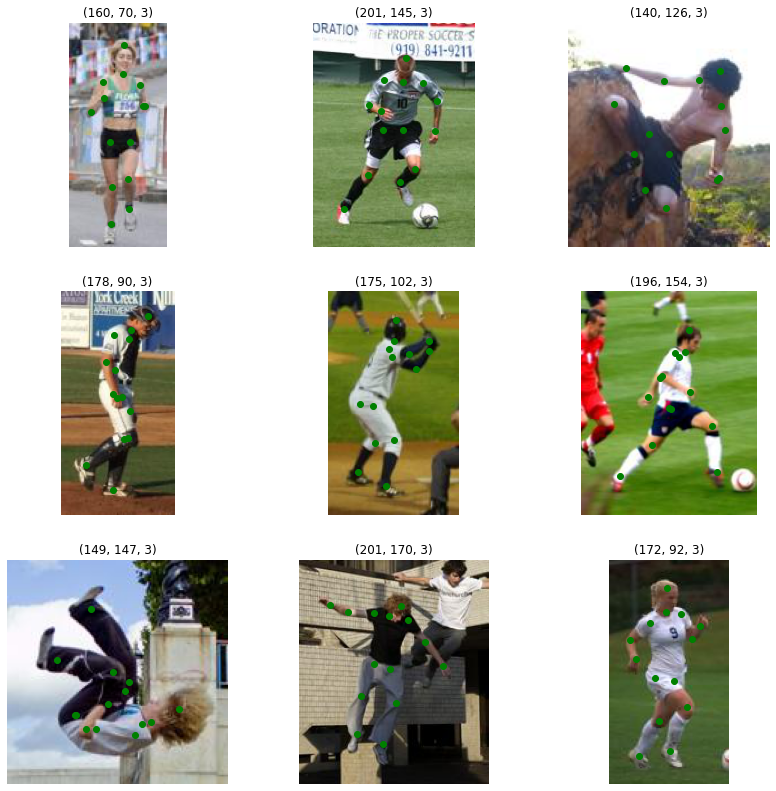

In [14]:
plt.figure(figsize=(14,14))
for idx in range(9):
  # idx = 1
  plt.subplot(3,3 , idx+1)
  image = plt.imread(f'images/im000{idx+1}.jpg')
  plt.axis('off')

  plt.title(str(image.shape))
  plt.imshow(image)
  coordinates = poses [0:2 , : , idx]
  plt.scatter(coordinates[0,:] , coordinates [1 ,: ],c='g',label='Original')

## found 1 corrupt sample!

150
154


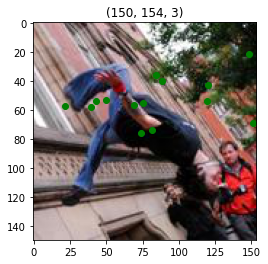

In [15]:
image = plt.imread(f'images/im0125.jpg')
# image = image.transpose((1, 0, 2))
height,width=image.shape[0],image.shape[1]
print(height)   # dim 0 image
print(width)    # dim 1 image
plt.title(str(image.shape))
plt.imshow(image)
coordinates = poses [0:2 , : , 125]
plt.scatter(coordinates[1,:] , coordinates [0 ,: ],c='g',label='Original')

## prepare data

In [16]:
images_directory=os.listdir('/content/images')
target_size=(220,220)
resized_images=[]
resized_poses=[]
std_poses = [] 
widthsnheights = []
originalImages = []
dictionaryOfTrainImages = {}
dictionaryOfTestImages = {}
dictionaryOfImages = {}
# datasetDictionary = {}
for idx,x in enumerate(images_directory):
    if idx+1 < 10 :  
      path = f'/content/images/im000{idx+1}.jpg'
    if idx+1>=10 and idx <100:
      path = f'/content/images/im00{idx+1}.jpg'
    if idx+1 >= 100 and idx <= 999 :
      path = f'/content/images/im0{idx+1}.jpg'
    if idx+1 >= 1000:
      path = f'/content/images/im{idx+1}.jpg'

    image = plt.imread(path)
    dictionaryOfImages [idx ] = image
    height, width=image.shape[0],image.shape[1]

    # looking for corrupt data!
    if  np.any (poses[0,:,idx] > width ):
      print("height " , idx)
    if np.any (poses [1,:,idx] > height ):
      print("width" , idx)

    # std_poses.append(  [ poses[0,:,idx]*220 / width ,    poses[1, : , idx]  *220/ height ])
    resized_poses.append (  [ poses[0,:,idx] / width*220     ,   poses[1, : , idx]  / height*220 ] )
    widthsnheights.append ( [ width  , height])
    image=cv2.resize(image,target_size,interpolation=cv2.INTER_AREA)
    resized_images.append(image)




resized_images=np.array(resized_images)
resized_poses=np.array(resized_poses)


trainkeys = np.arange(0 , 1600)
trainDict = {k: dictionaryOfImages[k] for k in trainkeys}

testkeys = np.arange(1600 , 2000)
testDict = {k: dictionaryOfImages[k] for k in testkeys}


x_train = resized_images[:1400]
y_train = resized_poses[:1400]
x_val = resized_images[1400:1700]
y_val = resized_poses[1400:1700]
x_test = resized_images[1700:]
y_test = resized_poses[1700:]


train_reconstruction_coefficient = widthsnheights[:1400]
validation_reconstruction_coefficient =widthsnheights [1400: 1700]
test_reconstruction_coefficient  =widthsnheights[1700:]

width 125


In [17]:
my_dataset = create_dataset (x_train , y_train ,x_val , y_val ,x_test , y_test , train_reconstruction_coefficient , validation_reconstruction_coefficient,  test_reconstruction_coefficient)

## training

In [18]:
#LRN->BN, Pooling->Strided Convolution
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same',input_shape=(220,220,3)))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu' , kernel_initializer = tf.keras.initializers.lecun_uniform))
model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu' , kernel_initializer = tf.keras.initializers.lecun_uniform))
model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu' , kernel_initializer = tf.keras.initializers.lecun_uniform))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(4096,activation='relu', kernel_initializer = tf.keras.initializers.lecun_uniform))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(4096,activation='relu' , kernel_initializer = tf.keras.initializers.lecun_uniform))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(28,activation='linear',  kernel_initializer = tf.keras.initializers.lecun_uniform))


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 48)        17472     
                                                                 
 lambda (Lambda)             (None, 55, 55, 48)        0         
                                                                 
 re_lu (ReLU)                (None, 55, 55, 48)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       153728    
                                                                 
 lambda_1 (Lambda)           (None, 28, 28, 128)       0         
                                                                 
 re_lu_1 (ReLU)              (None, 28, 28, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 192)       2

In [20]:
y_train_cat=np.concatenate((my_dataset['poses'][:,0],my_dataset['poses'][:,1]),axis=1)
y_val_cat=np.concatenate((my_dataset['val poses'][:,0],my_dataset['val poses'][:,1]),axis=1)
y_test_cat=np.concatenate((my_dataset['test poses'][:,0],my_dataset['test poses'][:,1]),axis=1)


model.compile(optimizer=tf.keras.optimizers.Adam( learning_rate= 0.0001 ),loss=tf.keras.losses.mean_squared_error)
training_history=model.fit(x=  my_dataset['images'],y= [y_train_cat],epochs=30 ,batch_size=32,validation_data=(my_dataset['val images'] ,  [y_val_cat]) ,verbose=1)


Epoch 1/30
44/44 [==============================] - 19s 164ms/step - loss: 0.0913 - val_loss: 0.0832
Epoch 2/30
44/44 [==============================] - 6s 144ms/step - loss: 0.0846 - val_loss: 0.0821
Epoch 3/30
44/44 [==============================] - 6s 145ms/step - loss: 0.0844 - val_loss: 0.0819
Epoch 4/30
44/44 [==============================] - 6s 145ms/step - loss: 0.0829 - val_loss: 0.0814
Epoch 5/30
44/44 [==============================] - 6s 144ms/step - loss: 0.0828 - val_loss: 0.0816
Epoch 6/30
44/44 [==============================] - 6s 144ms/step - loss: 0.0813 - val_loss: 0.0824
Epoch 7/30
44/44 [==============================] - 6s 145ms/step - loss: 0.0802 - val_loss: 0.0838
Epoch 8/30
44/44 [==============================] - 6s 144ms/step - loss: 0.0792 - val_loss: 0.0807
Epoch 9/30
44/44 [==============================] - 6s 143ms/step - loss: 0.0763 - val_loss: 0.0805
Epoch 10/30
44/44 [==============================] - 6s 145ms/step - loss: 0.0718 - val_loss: 0.084

In [21]:
model.evaluate(my_dataset['test images'] , [y_test_cat])

10/10 [==============================] - 1s 61ms/step - loss: 0.0852


0.08520763367414474

In [22]:
model.save('saved_final.h5')
# model =tf.keras.models.load_model('svdmdl')

## display

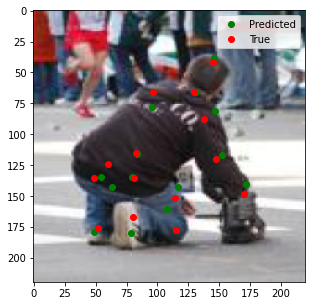

In [23]:
num = 10
compare_pose(num,model,0, my_dataset)

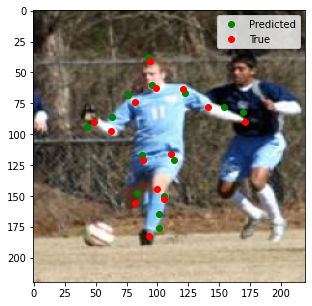

In [24]:
num = 20
compare_pose(num,model,0, my_dataset)

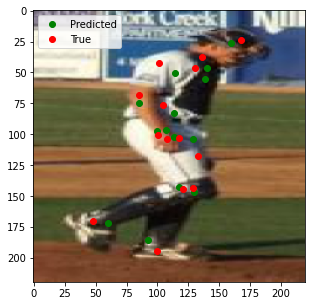

In [25]:
num = 3
compare_pose(num,model,0, my_dataset)

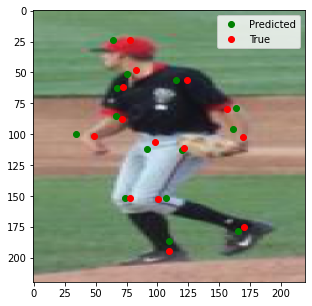

In [26]:
num = 88
compare_pose(num,model,0, my_dataset)

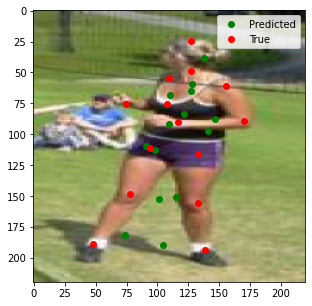

In [27]:
num = 88
compare_pose(num,model,1, my_dataset)

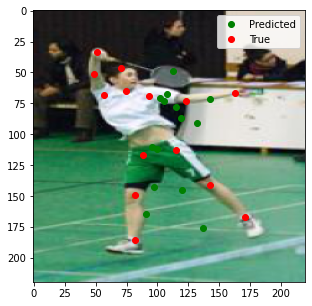

In [28]:
num = 51
compare_pose(num,model,1, my_dataset)

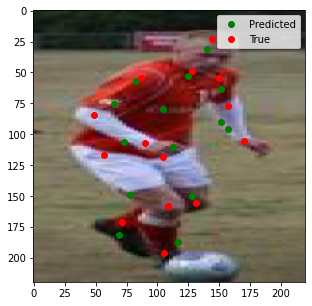

In [29]:
num = 230
compare_pose(num,model,1, my_dataset)

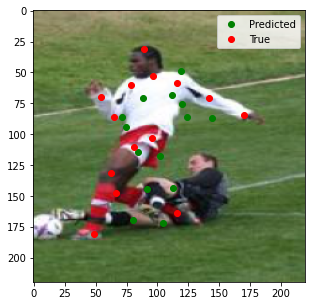

In [30]:
num = 2
compare_pose(num,model,1, my_dataset)

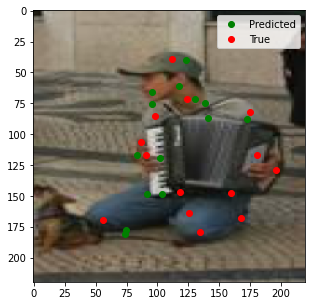

In [31]:
num = 4
compare_pose(num,model,1, my_dataset)

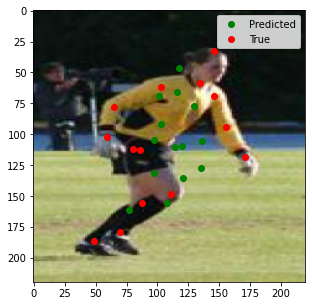

In [32]:
num = 6
compare_pose(num,model,1, my_dataset)

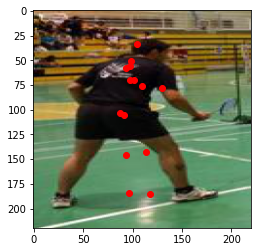

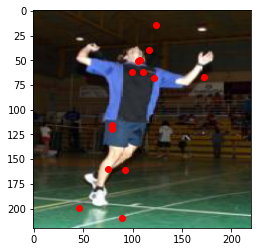

In [33]:
draw_pose('images/im0210.jpg' , model)
draw_pose('images/im0910.jpg' , model)

##metrics

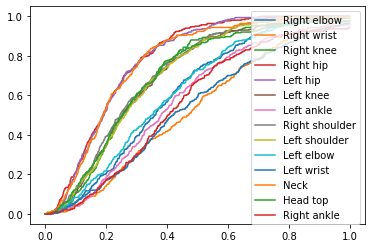

In [41]:
test_pdj(model,['Right wrist','Right elbow'])

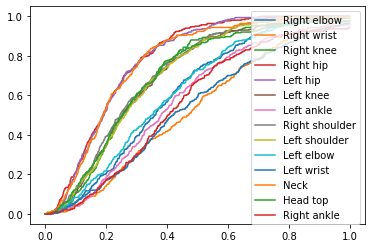

In [42]:
test_pcp(model,['Right wrist','Right elbow'])

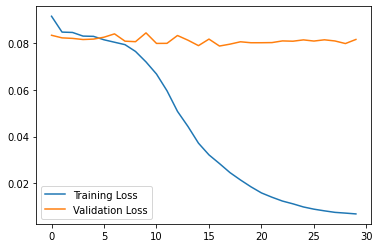

In [36]:
plt.plot(training_history.history['loss'],label='Training Loss')
plt.plot(training_history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()